# 决策树

In [4]:
from numpy import *
import numpy as np
import pandas as pd
from math import log
import operator
df=pd.read_csv('./data_watermelon/watermelon.data')
data=df.values[:,1:].tolist()
data_full=data[:]

### 通用方法

In [5]:
#对离散变量划分数据集，取出该特征取值为value的所有样本
def splitDataSet(dataSet,axis,value):
    retDataSet=[]
    for featVec in dataSet:
        if featVec[axis]==value:
            reducedFeatVec=featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet
 
#对连续变量划分数据集
#划分出小于value的数据样本和大于value的数据样本集
def splitContinuousDataSet(dataSet,axis,value):
    lessDataSet=[]
    moreDataSet=[]
    for featVec in dataSet:
        reducedFeatVec=featVec[:axis]
        reducedFeatVec.extend(featVec[axis+1:])
        if featVec[axis]>value:
            moreDataSet.append(reducedFeatVec)
        else:
            lessDataSet.append(reducedFeatVec)
    return lessDataSet, moreDataSet
#特征若已经划分完，节点下的样本还没有统一取值，则需要进行投票
def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote]=0
            classCount[vote]+=1
    return max(classCount)
# 创建无序属性的有序值
def formateNoOrderData(dataSet):
    # 建立各无序属性的set集
    map_label_value = {}
    for i in range(len(dataSet[0]) - 1):
        if type(newdata[0][i]).__name__ == 'str':
            map_label_value[i] = set([item[i] for item in dataSet])
    # 创建无序属性的有序值
    for i in map_label_value:
        l = len(map_label_value[i])
        map_value_index = {}
        for index, value in enumerate(map_label_value[i]):
            map_value_index[value] = index
        for item in dataSet:
            d = [0] * l
            d[map_value_index[item[i]]] = 1
            item[i] = d
    # 处理标签
    for item in dataSet:
        if item[-1] == '是':
            item[-1] = 1
        else:
            item[-1] = 0

### 统一画图方法

In [6]:
import matplotlib.pyplot as plt
decisionNode=dict(boxstyle="sawtooth",fc="0.8")
leafNode=dict(boxstyle="round4",fc="0.8")
arrow_args=dict(arrowstyle="<-")
 
 
#计算树的叶子节点数量
def getNumLeafs(myTree):
    numLeafs=0
    firstStr=list(myTree.keys())[0]
    secondDict=myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            numLeafs+=getNumLeafs(secondDict[key])
        else: numLeafs+=1
    return numLeafs
 
#计算树的最大深度
def getTreeDepth(myTree):
    maxDepth=0
    firstStr=list(myTree.keys())[0]
    secondDict=myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            thisDepth=1+getTreeDepth(secondDict[key])
        else: thisDepth=1
        if thisDepth>maxDepth:
            maxDepth=thisDepth
    return maxDepth
 
#画节点
def plotNode(nodeTxt,centerPt,parentPt,nodeType):
    createPlot.ax1.annotate(nodeTxt,xy=parentPt,xycoords='axes fraction',\
    xytext=centerPt,textcoords='axes fraction',va="center", ha="center",\
    bbox=nodeType,arrowprops=arrow_args)
 
#画箭头上的文字
def plotMidText(cntrPt,parentPt,txtString):
    lens=len(txtString)
    xMid=(parentPt[0]+cntrPt[0])/2.0-lens*0.002
    yMid=(parentPt[1]+cntrPt[1])/2.0
    createPlot.ax1.text(xMid,yMid,txtString)
    
def plotTree(myTree,parentPt,nodeTxt):
    numLeafs=getNumLeafs(myTree)
    depth=getTreeDepth(myTree)
    firstStr=list(myTree.keys())[0]
    cntrPt=(plotTree.x0ff+(1.0+float(numLeafs))/2.0/plotTree.totalW,plotTree.y0ff)
    plotMidText(cntrPt,parentPt,nodeTxt)
    plotNode(firstStr,cntrPt,parentPt,decisionNode)
    secondDict=myTree[firstStr]
    plotTree.y0ff=plotTree.y0ff-1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            plotTree(secondDict[key],cntrPt,str(key))
        else:
            plotTree.x0ff=plotTree.x0ff+1.0/plotTree.totalW
            plotNode(secondDict[key],(plotTree.x0ff,plotTree.y0ff),cntrPt,leafNode)
            plotMidText((plotTree.x0ff,plotTree.y0ff),cntrPt,str(key))
    plotTree.y0ff=plotTree.y0ff+1.0/plotTree.totalD
 
def createPlot(inTree):
    # 对中文的支持
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    fig=plt.figure(1,facecolor='white')
    fig.clf()
    axprops=dict(xticks=[],yticks=[])
    createPlot.ax1=plt.subplot(111,frameon=False,**axprops)
    plotTree.totalW=float(getNumLeafs(inTree))
    plotTree.totalD=float(getTreeDepth(inTree))
    plotTree.x0ff=-0.5/plotTree.totalW
    plotTree.y0ff=1.0
    plotTree(inTree,(0.5,1.0),'')
    plt.show()

## ID3
### 信息熵公式:
$$Ent(D) = -\sum_{k=1}^{|y|}p_klog_2p_k .$$
当前样本集合*D*中第*k*类样本所占的比例为$p_k (k = 1,2,3,...,|y|)$
### 信息增益
#### 离散型
$$Gain(D,a) = Ent(D) - \sum_{v=1}^{|V|}\frac {|D^v|}{|D|}Ent(D^v) .$$

#### 连续型
$$
\begin{aligned}
Gain(D,a) &= \max_{t \in T_a} Gain(D,a,t) \\  
&= \max_{t \in T_a} \left[Ent(D) - \sum_{\lambda \in \{-,+\}} \frac {|D_t^\lambda|}{|D|}Ent(D_t^\lambda)\right]\\ 
\end{aligned}
$$
其中$Gain(D,a,t)$是样本集*D*基于划分点*t*二分后的信息增益

In [7]:
#计算数据集的香农熵
def calcShannonEnt(dataSet):
    numEntries=len(dataSet)
    labelCounts={}
    #给所有可能分类创建字典
    for featVec in dataSet:
        currentLabel=featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel]=0
        labelCounts[currentLabel]+=1
    shannonEnt=0.0
    #以2为底数计算香农熵
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt-=prob*log(prob,2)
    return shannonEnt
# 计算数据集的Gain
def calcInfoGain(dataSet, axis, uniqueVals=None, value=None):
    newEntropy = 0.0
    if uniqueVals:
        # 离散型
        for value in uniqueVals:
            subDataSet=splitDataSet(dataSet,axis,value)
            prob=len(subDataSet)/float(len(dataSet))
            newEntropy+=prob*calcShannonEnt(subDataSet)
    else:
        # 连续型
        subDataSet0, subDataSet1=splitContinuousDataSet(dataSet,axis,value)
        prob0=len(subDataSet0)/float(len(dataSet))
        newEntropy+=prob0*calcShannonEnt(subDataSet0)
        prob1=len(subDataSet1)/float(len(dataSet))
        newEntropy+=prob1*calcShannonEnt(subDataSet1)
    return newEntropy
#选择最好的数据集划分方式
def chooseBestFeatureToSplit_ID3(dataSet,labels):
    numFeatures=len(dataSet[0])-1
    baseEntropy=calcShannonEnt(dataSet)
    bestInfoGain=0.0
    bestFeature=-1
    bestSplitDict={}
    for i in range(numFeatures):
        featList=[example[i] for example in dataSet]
        #对连续型特征进行处理
        if type(featList[0]).__name__=='float' or type(featList[0]).__name__=='int':
            #产生n-1个候选划分点
            sortfeatList=sorted(featList)
            splitList=[]
            for j in range(len(sortfeatList)-1):
                splitList.append((sortfeatList[j]+sortfeatList[j+1])/2.0)
            
            bestSplitEntropy=10000
            slen=len(splitList)
            #求用第j个候选划分点划分时，得到的信息熵，并记录最佳划分点
            for j in range(slen):
                value=splitList[j]
                newEntropy=calcInfoGain(dataSet, i, value = value)
                if newEntropy<bestSplitEntropy:
                    bestSplitEntropy=newEntropy
                    bestSplit=j
            #用字典记录当前特征的最佳划分点
            bestSplitDict[labels[i]]=splitList[bestSplit]
            infoGain=baseEntropy-bestSplitEntropy
        #对离散型特征进行处理
        else:
            uniqueVals=set(featList)
            #计算该特征下每种划分的信息熵
            newEntropy=calcInfoGain(dataSet, i, uniqueVals)
            infoGain=baseEntropy-newEntropy
        if infoGain>bestInfoGain:
            bestInfoGain=infoGain
            bestFeature=i
    #若当前节点的最佳划分特征为连续特征，则将其以之前记录的划分点为界进行二值化处理
    #即是否小于等于bestSplitValue
    if type(dataSet[0][bestFeature]).__name__=='float' or type(dataSet[0][bestFeature]).__name__=='int':      
        bestSplitValue=bestSplitDict[labels[bestFeature]]        
        labels[bestFeature]=labels[bestFeature]+'<='+str(bestSplitValue)
        for i in range(shape(dataSet)[0]):
            if dataSet[i][bestFeature]<=bestSplitValue:
                dataSet[i][bestFeature]=1
            else:
                dataSet[i][bestFeature]=0
    return bestFeature
#主程序，递归产生决策树
def createTree_ID3(dataSet,labels,data_full,labels_full):
    classList=[example[-1] for example in dataSet]
    if classList.count(classList[0])==len(classList):
        return classList[0]
    if len(dataSet[0])==1:
        return majorityCnt(classList)
    bestFeat=chooseBestFeatureToSplit_ID3(dataSet,labels)
    bestFeatLabel=labels[bestFeat]
    myTree={bestFeatLabel:{}}
    featValues=[example[bestFeat] for example in dataSet]
    uniqueVals=set(featValues)
    if type(dataSet[0][bestFeat]).__name__=='str':
        currentlabel=labels_full.index(labels[bestFeat])
        featValuesFull=[example[currentlabel] for example in data_full]
        uniqueValsFull=set(featValuesFull)
    del(labels[bestFeat])
    #针对bestFeat的每个取值，划分出一个子树。
    for value in uniqueVals:
        subLabels=labels[:]
        if type(dataSet[0][bestFeat]).__name__=='str':
            uniqueValsFull.remove(value)
        myTree[bestFeatLabel][value]=createTree_ID3(splitDataSet\
        (dataSet,bestFeat,value),subLabels,data_full,labels_full)
    if type(dataSet[0][bestFeat]).__name__=='str':
        for value in uniqueValsFull:
            myTree[bestFeatLabel][value]=majorityCnt(classList)
    return myTree

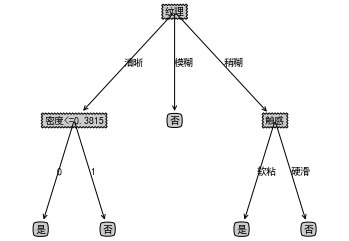

In [8]:
labels=df.columns.values[1:-1].tolist()
labels_full=labels[:]
myTree=createTree_ID3(data,labels,data_full,labels_full)
createPlot(myTree)

## CART
### 基尼值
$$
\begin{equation}\begin{split} 
Gini(D) &= \sum_{k=1}^{|y|} \sum_{k' \ne k} p_kp_{k'}\\
&= 1 - \sum_{k=1}^{|y|}p_k^2
\end{split}\end{equation}
$$
### 基尼指数
#### 离散型
$$Gini\_index(D,a) = \sum_{v=1}^{|V|}\frac {|D^v|}{|D|}Gini(D^v)$$
#### 连续型
$$Gini\_index(D,a) =\min_{t \in T_a} \left[\sum_{\lambda \in \{-,+\}} \frac {|D_t^\lambda|}{|D|}Gini(D_t^\lambda)\right]$$

In [9]:
#计算数据集的基尼值
def calcGini(dataSet):
    numEntries=len(dataSet)
    labelCounts={}
    #给所有可能分类创建字典
    for featVec in dataSet:
        currentLabel=featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel]=0
        labelCounts[currentLabel]+=1
    Gini=1.0
    #以2为底数计算基尼值
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        Gini-=prob*prob
    return Gini
# 计算数据集的Gini_index
def calcInfoGini_index(dataSet, axis, uniqueVals=None, value=None):
    newGiniIndex = 0.0
    if uniqueVals:
        # 离散型
        for value in uniqueVals:
            subDataSet=splitDataSet(dataSet,axis,value)
            prob=len(subDataSet)/float(len(dataSet))
            newGiniIndex+=prob*calcGini(subDataSet)
    else:
        # 连续型
        subDataSet0, subDataSet1=splitContinuousDataSet(dataSet,axis,value)
        prob0=len(subDataSet0)/float(len(dataSet))
        newGiniIndex+=prob0*calcGini(subDataSet0)
        prob1=len(subDataSet1)/float(len(dataSet))
        newGiniIndex+=prob1*calcGini(subDataSet1)
    return newGiniIndex
#选择最好的数据集划分方式
def chooseBestFeatureToSplit_CART(dataSet,labels):
    numFeatures=len(dataSet[0])-1
    bestGiniIndex=100000.0
    bestFeature=-1
    bestSplitDict={}
    for i in range(numFeatures):
        featList=[example[i] for example in dataSet]
        #对连续型特征进行处理
        if type(featList[0]).__name__=='float' or type(featList[0]).__name__=='int':
            #产生n-1个候选划分点
            sortfeatList=sorted(featList)
            splitList=[]
            for j in range(len(sortfeatList)-1):
                splitList.append((sortfeatList[j]+sortfeatList[j+1])/2.0)
            
            bestSplitGini=100000.0
            slen=len(splitList)
            #求用第j个候选划分点划分时，得到的信息熵，并记录最佳划分点
            for j in range(slen):
                value=splitList[j]
                newGiniIndex=calcInfoGini_index(dataSet, i, value = value)
                if newGiniIndex<bestSplitGini:
                    bestSplitGini=newGiniIndex
                    bestSplit=j
            #用字典记录当前特征的最佳划分点
            bestSplitDict[labels[i]]=splitList[bestSplit]
            GiniIndex=bestSplitGini
        #对离散型特征进行处理
        else:
            uniqueVals=set(featList)
            #计算该特征下每种划分的信息熵
            newGiniIndex=calcInfoGini_index(dataSet, i, uniqueVals)
            GiniIndex=newGiniIndex
        if GiniIndex<bestGiniIndex:
            bestGiniIndex=GiniIndex
            bestFeature=i
    #若当前节点的最佳划分特征为连续特征，则将其以之前记录的划分点为界进行二值化处理
    #即是否小于等于bestSplitValue
    if type(dataSet[0][bestFeature]).__name__=='float' or type(dataSet[0][bestFeature]).__name__=='int':      
        bestSplitValue=bestSplitDict[labels[bestFeature]]        
        labels[bestFeature]=labels[bestFeature]+'<='+str(bestSplitValue)
        for i in range(shape(dataSet)[0]):
            if dataSet[i][bestFeature]<=bestSplitValue:
                dataSet[i][bestFeature]=1
            else:
                dataSet[i][bestFeature]=0
    return bestFeature
#主程序，递归产生决策树
def createTree_CART(dataSet,labels,data_full,labels_full):
    classList=[example[-1] for example in dataSet]
    if classList.count(classList[0])==len(classList):
        return classList[0]
    if len(dataSet[0])==1:
        return majorityCnt(classList)
    bestFeat=chooseBestFeatureToSplit_CART(dataSet,labels)
    bestFeatLabel=labels[bestFeat]
    myTree={bestFeatLabel:{}}
    featValues=[example[bestFeat] for example in dataSet]
    uniqueVals=set(featValues)
    if type(dataSet[0][bestFeat]).__name__=='str':
        currentlabel=labels_full.index(labels[bestFeat])
        featValuesFull=[example[currentlabel] for example in data_full]
        uniqueValsFull=set(featValuesFull)
    del(labels[bestFeat])
    #针对bestFeat的每个取值，划分出一个子树。
    for value in uniqueVals:
        subLabels=labels[:]
        if type(dataSet[0][bestFeat]).__name__=='str':
            uniqueValsFull.remove(value)
        myTree[bestFeatLabel][value]=createTree_CART(splitDataSet\
        (dataSet,bestFeat,value),subLabels,data_full,labels_full)
    if type(dataSet[0][bestFeat]).__name__=='str':
        for value in uniqueValsFull:
            myTree[bestFeatLabel][value]=majorityCnt(classList)
    return myTree

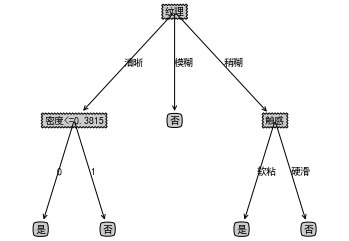

In [10]:
labels=df.columns.values[1:-1].tolist()
labels_full=labels[:]
myTree=createTree_CART(data,labels,data_full,labels_full)
createPlot(myTree)

## 基于logit回归实现决策树
### 

In [71]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
# 训练logit函数 并 将数据转为对应标签
def train_logit_and_tran_data(dataSet):
    y_train = np.array([item[-1] for item in dataSet],dtype=np.float32)
    y_train = mat(y_train)
    for l in range(len(dataSet[0]) - 1):
        x_train = np.array([item[l] for item in dataSet],dtype=np.float32)
        if type(x_train[0]).__name__=='float32':
            dim = 1
        else:
            dim = len(x_train[0])
        w=tf.Variable(tf.zeros([dim,1]))
        b=tf.Variable(tf.zeros([1,1]))
        if dim == 1:
            y=1/(1+tf.exp(-(x_train*w+b)))
        else:
            y=1/(1+tf.exp(-(tf.matmul(x_train,w)+b)))
        loss = tf.reduce_mean(- y_train.reshape(-1, 1) * tf.math.log(y) - (1 - y_train.reshape(-1, 1)) * tf.math.log(1 - y))
        train=tf.compat.v1.train.GradientDescentOptimizer(0.5).minimize(loss)
        
        with tf.compat.v1.Session() as sess:
            init=tf.compat.v1.global_variables_initializer()
            sess.run(init)
            for i in range(1000):
                sess.run(train)
            if dim > 1:
                tran_data = tf.matmul(x_train,w)+b
            else:
                x_train = mat(x_train)
                tran_data = x_train.T * w + b
            tran_data = 1/(1+tf.exp(-tran_data))
            tran_data = tran_data.eval()
        for j, item in enumerate(dataSet):
            item[l] = tran_data[j][0]

    #选择最好的数据集划分方式
def chooseBestFeatureToSplit_Logit(dataSet,labels):
    numFeatures=len(dataSet[0])-1
    baseEntropy=calcShannonEnt(dataSet)
    bestInfoGain=0.0
    bestFeature=-1
    bestSplitDict={}
    for i in range(numFeatures):
        featList=[example[i] for example in dataSet]
        # 经过前期处理，所有数据都变成连续值
        # 对连续型特征进行处理

        # 方法一
        # 从0到1 隔0.1采样，选择合理的阈值
        # splitList=np.linspace(0,1,11)

        # 方法二
        # 只取0.5
        splitList = [0.5]

        bestSplitEntropy=10000
        slen=len(splitList)
        #求用第j个候选划分点划分时，得到的信息熵，并记录最佳划分点
        for j in range(slen):
            value=splitList[j]
            newEntropy=calcInfoGain(dataSet, i, value = value)
            if newEntropy<bestSplitEntropy:
                bestSplitEntropy=newEntropy
                bestSplit=j
        
        #用字典记录当前特征的最佳划分点
        bestSplitDict[labels[i]]=splitList[bestSplit]
        infoGain=baseEntropy-bestSplitEntropy
        if infoGain>bestInfoGain:
            bestInfoGain=infoGain
            bestFeature=i
    #当前节点的最佳划分特征为连续特征，则将其以之前记录的划分点为界进行二值化处理
    #即是否小于等于bestSplitValue    
    bestSplitValue=bestSplitDict[labels[bestFeature]]        
    labels[bestFeature]=labels[bestFeature]+'<='+str(bestSplitValue)
    for i in range(shape(dataSet)[0]):
        if dataSet[i][bestFeature]<=bestSplitValue:
            dataSet[i][bestFeature]=1
        else:
            dataSet[i][bestFeature]=0
    return bestFeature
#主程序，递归产生决策树
def createTree_Logit(dataSet,labels):
    classList=[example[-1] for example in dataSet]
    if classList.count(classList[0])==len(classList):
        return classList[0]
    if len(dataSet[0])==1:
        return majorityCnt(classList)
    bestFeat=chooseBestFeatureToSplit_Logit(dataSet,labels)
    bestFeatLabel=labels[bestFeat]
    myTree={bestFeatLabel:{}}
    featValues=[example[bestFeat] for example in dataSet]
    uniqueVals=set(featValues)
    del(labels[bestFeat])
    #针对bestFeat的每个取值，划分出一个子树。
    for value in uniqueVals:
        subLabels=labels[:]
        myTree[bestFeatLabel][value]=createTree_Logit(splitDataSet\
        (dataSet,bestFeat,value),subLabels)
    return myTree    


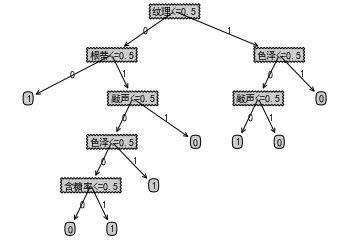

In [72]:
newdata=df.values[:,1:].tolist()
formateNoOrderData(newdata)
train_logit_and_tran_data(newdata)
labels=df.columns.values[1:-1].tolist()
# labels_full=labels[:]
# newdata_full=newdata[:]
myTree = createTree_Logit(newdata, labels)
createPlot(myTree)

## 预剪枝(基于CART)

In [ ]:
import re
def testingMajor(major,data):
    error=0.0
    for i in range(len(data)):
        if major!=data[i][-1]:
            error+=1
    
    return float(error)
 
def testingSubTree(bestFeatLabel, uniqueVals, featLabels, data):
    error=0.0
    if '<=' in bestFeatLabel:
        featvalue=float(re.compile("(<=.+)").search(bestFeatLabel).group()[2:])
        featkey=re.compile("(.+<=)").search(bestFeatLabel).group()[:-2]
        featIndex=featLabels.index(featkey)
        moreClassList = []
        lessClassList = []
        for item in data:
            if item[featIndex] <= featvalue:
                lessClassList.append(item[-1])
            else:
                moreClassList.append(item[-1])
        subDataSet0, subDataSet1=splitContinuousDataSet(data,featIndex,featvalue)
        error += testingMajor(majorityCnt(lessClassList), subDataSet1)
        error += testingMajor(majorityCnt(moreClassList), subDataSet0)
    else:
        for val in uniqueVals:
            classList = []
            valData = []
            featIndex=featLabels.index(bestFeatLabel)
            for item in data:
                if item[featIndex] == val:
                    classList.append(item[-1])
            subDataSet=splitDataSet(data,featIndex,val)
            error += testingMajor(majorityCnt(classList), subDataSet)
    
    return float(error)
#主程序，递归产生决策树(预剪枝)
import copy
def createTreebyPre(dataSet,labels,data_full,labels_full):
    classList=[example[-1] for example in dataSet]
    if classList.count(classList[0])==len(classList):
        return classList[0]
    if len(dataSet[0])==1:
        return majorityCnt(classList)
    temp_labels=copy.deepcopy(labels)
    bestFeat=chooseBestFeatureToSplit_CART(dataSet,labels)
    bestFeatLabel=labels[bestFeat]
    myTree={bestFeatLabel:{}}
    featValues=[example[bestFeat] for example in dataSet]
    uniqueVals=set(featValues)
    if type(dataSet[0][bestFeat]).__name__=='str':
        currentlabel=labels_full.index(labels[bestFeat])
        featValuesFull=[example[currentlabel] for example in data_full]
        uniqueValsFull=set(featValuesFull)
    del(labels[bestFeat])
    #针对bestFeat进行预判，看是剪枝还是生成子树
    mClass = majorityCnt(classList)
    if testingSubTree(bestFeatLabel, uniqueVals, temp_labels, dataSet) < testingMajor(mClass,dataSet):
        for value in uniqueVals:
            subLabels=labels[:]
            if type(dataSet[0][bestFeat]).__name__=='str':
                uniqueValsFull.remove(value)
            myTree[bestFeatLabel][value]=createTreebyPre(splitDataSet\
            (dataSet,bestFeat,value),subLabels,data_full,labels_full)
        if type(dataSet[0][bestFeat]).__name__=='str':
            for value in uniqueValsFull:
                myTree[bestFeatLabel][value]=majorityCnt(classList)
        return myTree
    return mClass

In [ ]:
labels=df.columns.values[1:-1].tolist()
labels_full=labels[:]
myTree=createTreebyPre(data,labels,data_full,labels_full)
createPlot(myTree)

## 后剪枝(基于CART)

In [ ]:
#由于在Tree中，连续值特征的名称以及改为了  feature<=value的形式
#因此对于这类特征，需要利用正则表达式进行分割，获得特征名以及分割阈值
def classify(inputTree,featLabels,testVec):
    firstStr=list(inputTree.keys())[0]
    if '<=' in firstStr:
        featvalue=float(re.compile("(<=.+)").search(firstStr).group()[2:])
        featkey=re.compile("(.+<=)").search(firstStr).group()[:-2]
        secondDict=inputTree[firstStr]
        featIndex=featLabels.index(featkey)
        if testVec[featIndex]<=featvalue:
            judge=1
        else:
            judge=0
        for key in secondDict.keys():
            if judge==int(key):
                if type(secondDict[key]).__name__=='dict':
                    classLabel=classify(secondDict[key],featLabels,testVec)
                else:
                    classLabel=secondDict[key]
    else:
        secondDict=inputTree[firstStr]
        featIndex=featLabels.index(firstStr)
        for key in secondDict.keys():
            if testVec[featIndex]==key:
                if type(secondDict[key]).__name__=='dict':
                    classLabel=classify(secondDict[key],featLabels,testVec)
                else:
                    classLabel=secondDict[key]
    return classLabel
#测试决策树正确率
def testing(myTree,data_test,labels):
    error=0.0
    for i in range(len(data_test)):
        if classify(myTree,labels,data_test[i])!=data_test[i][-1]:
            error+=1
    #print 'myTree %d' %error
    return float(error)
#测试投票节点正确率
def testingMajor(major,data_test):
    error=0.0
    for i in range(len(data_test)):
        if major!=data_test[i][-1]:
            error+=1
    #print 'major %d' %error
    return float(error)
#主程序，递归产生决策树(后剪枝)
import copy
def createTreebyPost(dataSet,labels,data_full,labels_full):
    classList=[example[-1] for example in dataSet]
    if classList.count(classList[0])==len(classList):
        return classList[0]
    if len(dataSet[0])==1:
        return majorityCnt(classList)
    temp_labels=copy.deepcopy(labels)
    bestFeat=chooseBestFeatureToSplit_CART(dataSet,labels)
    bestFeatLabel=labels[bestFeat]
    myTree={bestFeatLabel:{}}
    featValues=[example[bestFeat] for example in dataSet]
    uniqueVals=set(featValues)
    if type(dataSet[0][bestFeat]).__name__=='str':
        currentlabel=labels_full.index(labels[bestFeat])
        featValuesFull=[example[currentlabel] for example in data_full]
        uniqueValsFull=set(featValuesFull)
    del(labels[bestFeat])
    #针对bestFeat的每个取值，划分出一个子树。
    for value in uniqueVals:
        subLabels=labels[:]
        if type(dataSet[0][bestFeat]).__name__=='str':
            uniqueValsFull.remove(value)
        myTree[bestFeatLabel][value]=createTree_CART(splitDataSet\
        (dataSet,bestFeat,value),subLabels,data_full,labels_full)
    if type(dataSet[0][bestFeat]).__name__=='str':
        for value in uniqueValsFull:
            myTree[bestFeatLabel][value]=majorityCnt(classList)
    # 当某一节点的子树生成后，开始判别是否需要剪枝
    if testing(myTree,dataSet,temp_labels)<=testingMajor(majorityCnt(classList),dataSet):
        return myTree
    return majorityCnt(classList)

In [ ]:
labels=df.columns.values[1:-1].tolist()
labels_full=labels[:]
myTree=createTreebyPost(data,labels,data_full,labels_full)
createPlot(myTree)